In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import anndata
import time
import matplotlib.pyplot as plt

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache
from abc_atlas_access.abc_atlas_cache.anndata_utils import get_gene_data

In [62]:
download_base = Path('E:/seq_analysis/data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(download_base)
allen_ccf_list = abc_cache.get_directory_metadata('Zeng-Aging-Mouse-10Xv3')
abc_cache.get_data_path(directory='Zeng-Aging-Mouse-10Xv3', file_name='Zeng-Aging-Mouse-10Xv3/log2')
abc_cache.get_data_path(directory='Zeng-Aging-Mouse-10Xv3', file_name='Zeng-Aging-Mouse-10Xv3/raw')

WindowsPath('E:/seq_analysis/data/abc_atlas/expression_matrices/Zeng-Aging-Mouse-10Xv3/20241130/Zeng-Aging-Mouse-10Xv3-raw.h5ad')

In [ ]:
# Save the dataset in each cluster
# data_path = abc_cache.get_data_path(directory='Zeng-Aging-Mouse-10Xv3', file_name='Zeng-Aging-Mouse-10Xv3/log2')
data_path = f'D:/rna_data/Zeng-Aging-Mouse-10Xv3-log2.h5ad'
data_log2 = anndata.read_h5ad(data_path, backed='r')
data_log2.obs['sex'] = df_cell_metadata['donor_sex'].to_list()
data_log2.obs['age_category'] = df_cell_metadata['donor_age_category'].to_list()
for cluster, df in df_cell_metadata.groupby('cluster_alias'):
    index = df.index
    # print(len(index))
    # print(data_log2_subset)
    try:
        data_log2_subset = data_log2[index, :].to_memory()
        data_log2_subset.write(f"cluster/{cluster}.h5ad")
    except Exception as e:
        print(e, cluster, len(index))


In [132]:
len(df_cluster)

847

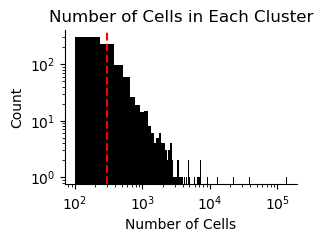

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
plt.hist(df_cluster['number_of_cells'], bins = 1000, color='black')
plt.axvline(x=np.median(df_cluster['number_of_cells']), color='red', linestyle='--')
plt.xlabel('Number of Cells')
plt.ylabel('Count')
plt.xscale('log')
plt.yscale('log')
plt.title('Number of Cells in Each Cluster')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()



In [72]:
# load h5ad file
cluster_alias = 389
adata_cluster = anndata.read_h5ad(f'cluster/{cluster_alias}.h5ad')
print(adata_cluster)
cluster = df_cluster[df_cluster['cluster_alias'] == cluster_alias]
cluster.head()


AnnData object with n_obs × n_vars = 398 × 32285
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label', 'alignment_job_id', 'sex', 'age_category'
    var: 'gene_symbol'


,cluster_alias,number_of_cells,cluster_label,cluster_order,cluster_name,cluster_color,max_region_of_interest_label,proportion_max_region_of_interest_label,number_of_adult_cells,number_of_aged_cells,proportion_adult_cells,proportion_aged_cells,odds_ratio,log2_odds_ratio,cluster_age_bias,max_region_of_interest_color,cluster_age_bias_color,neurotransmitter_combined_label,neurotransmitter_label,neurotransmitter_color
388,389,398,CS20241021_0389,388,389_PVH-SO-PVa Otp Glut_4,#2eadb9,HY - HY,0.512563,212,186,0.532663,0.467337,0.485575,-1.042233,unassigned,#E64438,#DADEDF,Glut,Glut,#2B93DF


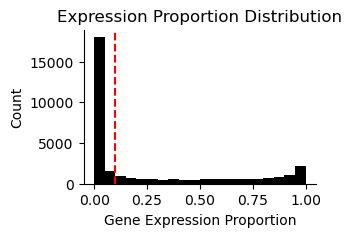

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
gene_proportion = (adata_cluster.X.toarray() > 0).mean(axis = 0)
plt.hist(gene_proportion, bins = 20, color='black')
plt.xlabel('Gene Expression Proportion')
plt.ylabel('Count')
plt.title('Expression Proportion Distribution')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.axvline(x=0.1, color='red', linestyle='--')
plt.show()



In [76]:
gene_index = np.where(gene_proportion > 0.1)[0]
gene_list = adata_cluster.var.iloc[gene_index].gene_symbol.to_list()
len(gene_list)

12762

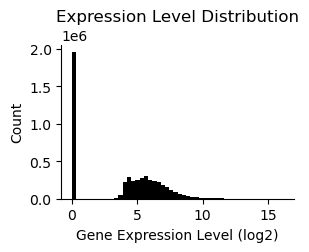

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
plt.hist(adata_cluster.X.toarray()[:, gene_index].flatten(), bins = 50, color='black')
plt.xlabel('Gene Expression Level (log2)')
plt.ylabel('Count')
plt.title('Expression Level Distribution')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()




In [78]:
data = {}
for (sex, age_category), df in adata_cluster.obs.groupby(['sex', 'age_category']):
    data[(sex, age_category)] = adata_cluster[df.index, gene_index].X.toarray()
    print(data[(sex, age_category)].shape)

(89, 12762)
(57, 12762)
(123, 12762)
(129, 12762)


C:\Users\bjmiao\AppData\Local\Temp\ipykernel_28488\1900240384.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (sex, age_category), df in adata_cluster.obs.groupby(['sex', 'age_category']):


## DE analysis

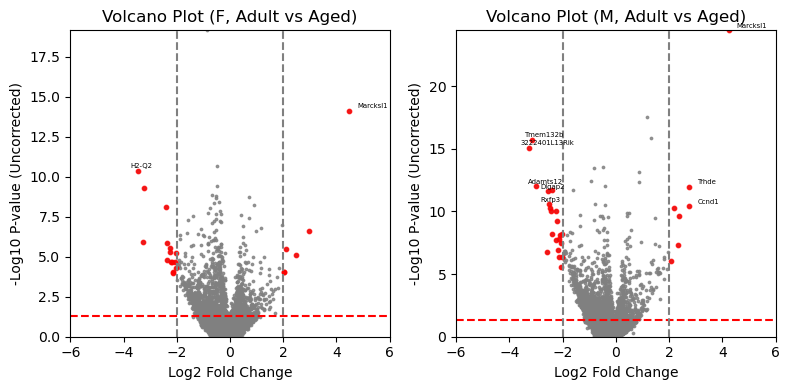

In [146]:
# conduct Wilcoxon test for 'F' and 'M'
from scipy.stats import ranksums
# Create a figure and axis
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for index, sex in enumerate(['F', 'M']):
    group1 = data[sex, 'adult']
    group2 = data[sex, 'aged']
    stats, p = (ranksums(group1, group2))
    neg_log10_p_values = -np.log10(p)
    log2_fold_change = group1.mean(axis = 0) - group2.mean(axis = 0)

    # Define significance thresholds
    log2_fc_threshold = 2
    p_value_threshold = 0.05

    ax = axs[index]
    # Plot the data points
    ax.scatter(log2_fold_change, neg_log10_p_values, s=3, alpha=0.8, color='gray')
    # Highlight significant genes
    significant_genes = (abs(log2_fold_change) > log2_fc_threshold) & (p < p_value_threshold)
    for i in np.where(significant_genes)[0]:
        if abs(neg_log10_p_values[i]) > 10 and abs(log2_fold_change[i]) > 2.5:
            ax.text(log2_fold_change[i] + 0.3 * np.sign(log2_fold_change[i]), neg_log10_p_values[i] + 0.2, gene_list[i], fontsize=5)
    ax.scatter(log2_fold_change[significant_genes], neg_log10_p_values[significant_genes],
            s=10, alpha=0.8, color='red')

    # Add horizontal and vertical lines for thresholds
    ax.axhline(-np.log10(p_value_threshold), linestyle='--', color='red', linewidth=1.5)
    ax.axvline(-log2_fc_threshold, linestyle='--', color='gray', linewidth=1.5)
    ax.axvline(log2_fc_threshold, linestyle='--', color='gray', linewidth=1.5)

    # Set the axis labels and title
    ax.set_xlabel('Log2 Fold Change')
    ax.set_ylabel('-Log10 P-value (Uncorrected)')
    ax.set_title(f'Volcano Plot ({sex}, Adult vs Aged)')

    # Adjust the axis limits
    ax.set_xlim(-6, 6)
    ax.set_ylim(0, -np.log10(p.min()))

# Display the plot
plt.tight_layout()
plt.show()

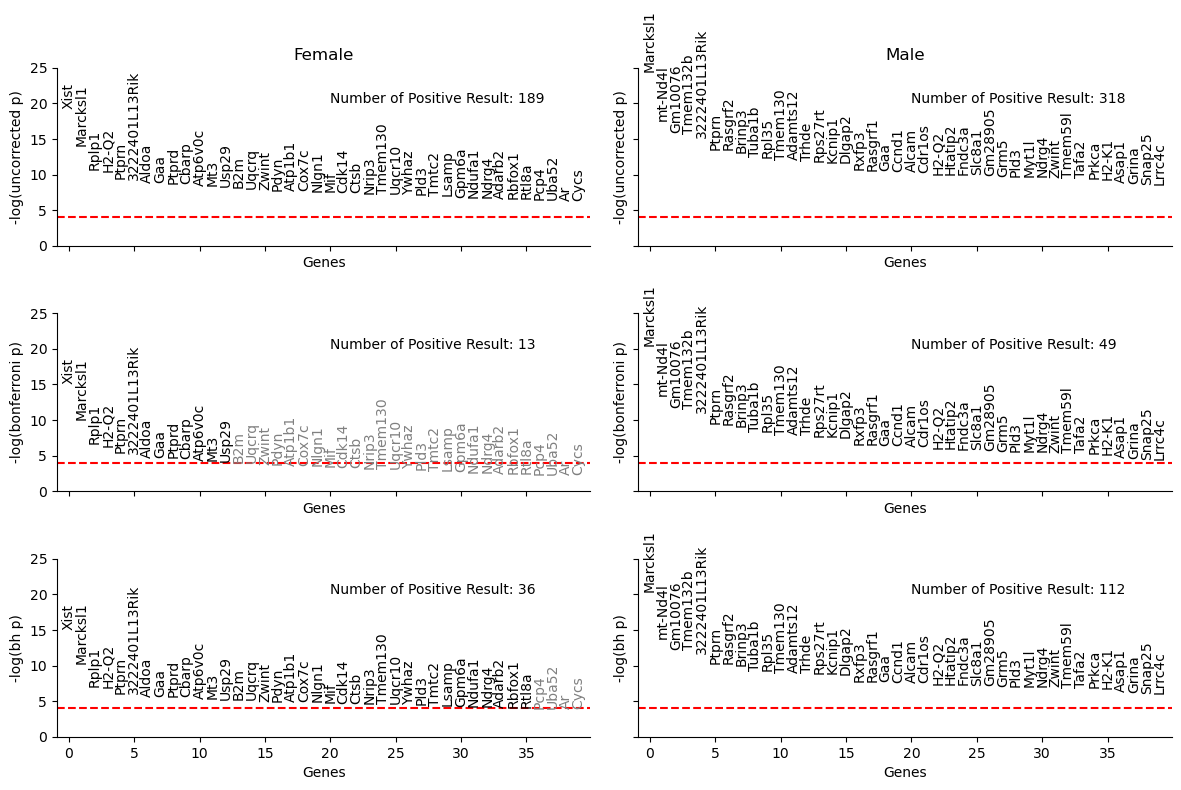

In [149]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8), sharex=True, sharey=True)
n_top_gene = 40
p_value_threshold = 1e-4

axs[0, 0].set_xlim(-0.9, n_top_gene - 0.1)
axs[0, 0].set_ylim(0, 25)
for index, sex in enumerate(['F', 'M']):
    group1 = data[sex, 'adult']
    group2 = data[sex, 'aged']
    stats, p = (ranksums(group1, group2))
    
    p_sort_index = np.argsort(p)
    p_sorted = p[p_sort_index]
    gene_list_sorted = np.array(gene_list)[p_sort_index]

    p_bonferroni = p_sorted * len(gene_list)
    p_bonferroni[p_bonferroni > 1] = 1
    p_bh = p_sorted * len(gene_list) / np.arange(1, len(gene_list) + 1)
    p_bh[p_bh > 1] = 1

    for label, ax, p_list in zip(('-log(uncorrected p)', '-log(bonferroni p)', '-log(bh p)'), (axs[0, index], axs[1, index], axs[2, index]), (p_sorted, p_bonferroni, p_bh)):
        for ig in range(n_top_gene):
            if p_list[ig] > p_value_threshold:
                color = 'grey'
            else:
                color = 'black'
            ax.text(ig, -np.log10(p_list[ig]), gene_list_sorted[ig], rotation="vertical", verticalalignment="bottom", horizontalalignment="center", color=color)
        ax.set_ylabel(label)
        ax.set_xlabel('Genes')
        ax.text(20, 20, f"Number of Positive Result: {np.sum(p_list < p_value_threshold)}", fontsize=10)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.axhline(-np.log10(p_value_threshold), linestyle='--', color='red', linewidth=1.5)
axs[0, 0].set_title('Female')
axs[0, 1].set_title('Male')
plt.tight_layout()
plt.show()



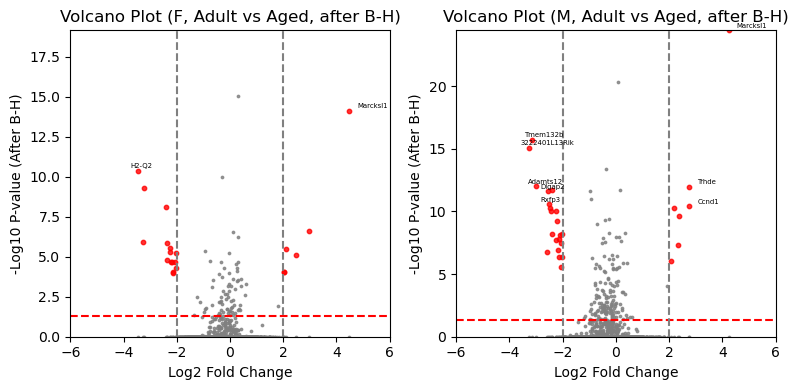

In [150]:
# conduct Wilcoxon test for 'F' and 'M'
from scipy.stats import ranksums
# Create a figure and axis
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for index, sex in enumerate(['F', 'M']):
    group1 = data[sex, 'adult']
    group2 = data[sex, 'aged']
    stats, p = (ranksums(group1, group2))
    neg_log10_p_values = -np.log10(p)
    log2_fold_change = group1.mean(axis = 0) - group2.mean(axis = 0)


    p_sort_index = np.argsort(p)
    p_sorted = p[p_sort_index]
    gene_list_sorted = np.array(gene_list)[p_sort_index]
    log2_fold_change_sorted = log2_fold_change[p_sort_index]
    p_bonferroni = p_sorted * len(gene_list)
    p_bonferroni[p_bonferroni > 1] = 1
    p_bh = p_sorted * len(gene_list) / np.arange(1, len(gene_list) + 1)
    p_bh[p_bh > 1] = 1
    # Define significance thresholds
    log2_fc_threshold = 2
    p_value_threshold = 0.05

    ax = axs[index]
    # Plot the data points
    ax.scatter(log2_fold_change, -np.log10(p_bonferroni), s=3, alpha=0.8, color='gray')
    # Highlight significant genes
    significant_genes = (abs(log2_fold_change) > log2_fc_threshold) & (p < p_value_threshold)
    for i in np.where(significant_genes)[0]:
        if abs(neg_log10_p_values[i]) > 10 and abs(log2_fold_change[i]) > 2.5:
            ax.text(log2_fold_change[i] + 0.3 * np.sign(log2_fold_change[i]), neg_log10_p_values[i] + 0.2, gene_list[i], fontsize=5)
    ax.scatter(log2_fold_change[significant_genes], neg_log10_p_values[significant_genes],
            s=10, alpha=0.8, color='red')

    # Add horizontal and vertical lines for thresholds
    ax.axhline(-np.log10(p_value_threshold), linestyle='--', color='red', linewidth=1.5)
    ax.axvline(-log2_fc_threshold, linestyle='--', color='gray', linewidth=1.5)
    ax.axvline(log2_fc_threshold, linestyle='--', color='gray', linewidth=1.5)

    # Set the axis labels and title
    ax.set_xlabel('Log2 Fold Change')
    ax.set_ylabel('-Log10 P-value (After B-H)')
    ax.set_title(f'Volcano Plot ({sex}, Adult vs Aged, after B-H)')

    # Adjust the axis limits
    ax.set_xlim(-6, 6)
    ax.set_ylim(0, -np.log10(p.min()))

# Display the plot
plt.tight_layout()
plt.show()

In [166]:
genes = {}
for index, sex in enumerate(['F', 'M']):
    group1 = data[sex, 'adult']
    group2 = data[sex, 'aged']
    stats, p = (ranksums(group1, group2))
    neg_log10_p_values = -np.log10(p)
    log2_fold_change = group1.mean(axis = 0) - group2.mean(axis = 0)

    p_sort_index = np.argsort(p)
    p_sorted = p[p_sort_index]
    gene_list_sorted = np.array(gene_list)[p_sort_index]
    log2_fold_change_sorted = log2_fold_change[p_sort_index]
    p_bonferroni = p_sorted * len(gene_list)
    p_bonferroni[p_bonferroni > 1] = 1
    p_bh = p_sorted * len(gene_list) / np.arange(1, len(gene_list) + 1)
    p_bh[p_bh > 1] = 1
    # Define significance thresholds
    log2_fc_threshold = 2
    p_value_threshold = 0.001
    significant_genes = (abs(log2_fold_change_sorted) > log2_fc_threshold) & (p_bh < p_value_threshold)
    genes[sex] = gene_list_sorted[significant_genes]
    print((genes[sex]))

['Marcksl1' 'H2-Q2' '3222401L13Rik' 'B2m' 'Adarb2' 'Rxfp1' 'Bcam' 'Rxfp3'
 'Fmnl2' 'Zc3hav1' 'Tsix']
['Marcksl1' 'Tmem132b' '3222401L13Rik' 'Adamts12' 'Trhde' 'Rps27rt'
 'Dlgap2' 'Rxfp3' 'Ccnd1' 'Alcam' 'Cdr1os' 'H2-Q2' 'Htatip2' 'Grm5'
 'H2-K1' 'Pla2r1' 'Vgf' 'Spred2' 'Grpr' 'Gm4876' 'Nnmt' 'Etl4' 'Th' 'Sncg'
 'Dkk3' 'Cpq' 'Epha6' 'Alk']


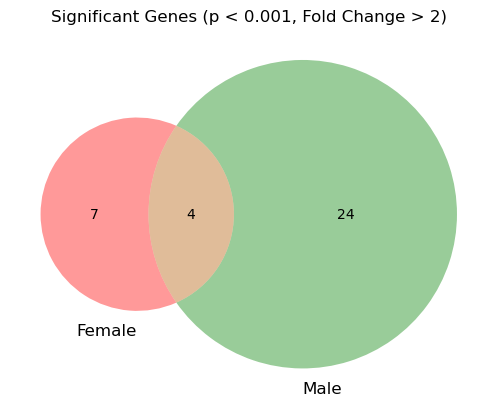

In [170]:
# plot ven diagram
import matplotlib_venn as venn
venn.venn2([set(genes['F']), set(genes['M'])], set_labels = ('Female', 'Male'))
plt.title('Significant Genes (p < 0.001, Fold Change > 2)')
plt.show()

